# Load project YAML from - Git, Zip, Tar source

After you created your project and you have a project.yaml files with all the necessery metadata you can simply load that project and run, build and deploy your functions and workflows.
Please run the Create CI/CD Automation Using - Git source example notebook before you are running this one

This notebook will go over those steps to load CI/CD project in MLRun:
1. Load or Create a new project for remote URL
2. Get a function object 
3. Run a function
4. Build a function
5. Deploy a function
6. Run a workflow

Install mlrun - if does not install use ``pip install mlrun==<mlrun server version>`` or ``sh align_mlrun.sh`` (our default mlrun installer - automatically install the server version)

In [1]:
import mlrun

#### Load or Create a new project Based on an exciting project.yaml file

MLRun provides you three option to create or loading a project:

1. [get_or_create_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=get_or_create_project#mlrun.projects.get_or_create_project) - this method allows you to load a project from MLRun DB or optionally load it from a yaml/zip/tar/git template, and create a new project if doesnt exist
2. [new_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=new_project#mlrun.projects.new_project) - Create a new MLRun project, optionally load it from a yaml/zip/tar/git template.
3. [load_project](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=load_project#mlrun.projects.load_project) - Load an MLRun project from yaml/zip/tar/git/dir or from MLRun db


In [2]:
#project source to load from
source = 'git://github.com/GiladShapira94/example-ci-cd.git#v1'

**Note -** Please add git branch or refs to the source e.g.: 'git://<url>/org/repo.git#<branch-name or refs/heads/..>'

In [3]:
project = mlrun.load_project('./clone',url=source,clone=True,name='my-load-proj-1')

**context -** project local directory path (default value = "./")

**url -**     name (in DB) or git or tar.gz or .zip sources archive

**clone -**   if True, always clone (delete any existing content)

**name -**    project name, if not use takes the value from the project.yaml file

By Specifying a url/remote address MLRun automatically clone your git repository or extract your tar/zip file

**Secrets -** for working with private repo you need to provide a Gittoken as a secrets using mlrun or mlrun UI, for example:
```
#while loading from private repo
project = mlrun.get_or_create_project(name='new-git-proj',context='./',init_git=True,secrest={"GIT_TOKEN":<github-token>})
#while running functions in a project from a private repo
project.set_secrets({"GIT_TOKEN":<github-token>}
```

In [4]:
#print project yaml
print(project.to_yaml())

kind: project
metadata:
  name: my-load-proj-1
spec:
  functions:
  - url: ./src/data_fetch.py
    name: data-fetch
    kind: job
    image: mlrun/mlrun
    handler: data_fetch
    with_repo: true
    tag: v1
  - url: ./src/train.py
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train
    with_repo: true
    tag: v1
  - url: ./src/serving.yaml
    name: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: model
    metadata:
      project: new-git-proj-shapira
      tag: v1
      key: model-test
    spec:
      target_path: v3io:///projects/new-git-proj-shapira/artifacts/a3df88a3-5d1f-4eab-b89e-773925e77a51/train/0/model/
      model_file: model.pkl
    status:
      state: created
  conda: ''
  source: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/v1
  origin_url: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/v1
  load_source_on_run: true
  desired_state: online



In [5]:
func = project.get_function('data-fetch',enrich=True)
print(func.to_yaml())

kind: job
metadata:
  name: data-fetch
  tag: v1
  project: my-load-proj-1
  categories: []
spec:
  command: ./src/data_fetch.py
  args: []
  image: mlrun/mlrun
  build:
    source: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/v1
    commands: []
    code_origin: https://github.com/GiladShapira94/example-ci-cd.git#57f8c5aae8f95f580974028a88191c951cfeb69b
    load_source_on_run: true
  description: ''
  default_handler: data_fetch
  disable_auto_mount: true
  volumes: []
  volume_mounts: []
  env:
  - name: V3IO_API
    value: v3io-webapi.default-tenant.svc:8081
  - name: V3IO_USERNAME
    value: shapira
  - name: V3IO_ACCESS_KEY
    value: 65e2966b-5c2b-4ea6-bf52-f2d0b829fe17
  - name: V3IO_FRAMESD
    value: framesd:8081
  resources:
    requests:
      memory: 1Mi
      cpu: 25m
    limits:
      memory: 20Gi
      cpu: '2'
  priority_class_name: igz-workload-medium
  preemption_mode: prevent
  affinity: null
  tolerations: null
  security_context: {}
verbose: false



In [6]:
func.run(returns=['train-dataset','test-dataset'])

> 2023-04-25 13:19:07,048 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '38c84855194a420e94120937ae9decf5', 'db': 'http://mlrun-api:8080'}
> 2023-04-25 13:19:07,330 [info] Job is running in the background, pod: data-fetch-data-fetch-6rvjl
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-1,...ae9decf5,0,Apr 25 13:19:11,completed,data-fetch-data-fetch,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.0mlrun/client_python_version=3.7.6host=data-fetch-data-fetch-6rvjl,,,,train-datasettest-dataset


> 2023-04-25 13:19:20,546 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


#### Run Function 
For run a function you will need to use the [project.run_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=run_function#mlrun.projects.MlrunProject.run_function) method.
This method allows you to run a MLRun jobs locally and remotely as long as there is no requirments ( if there is any requirments you will need to build a new image before you run a function)

In [7]:
project.run_function(function='data-fetch',local=True,returns=['train-dataset','test-dataset'])

> 2023-04-25 13:19:20,594 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '6d933dc0937d4f11a720062e8d87b4a9', 'db': 'http://mlrun-api:8080'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-1,...8d87b4a9,0,Apr 25 13:19:20,completed,data-fetch-data-fetch,v3io_user=shapirakind=owner=shapirahost=jupyter-shapira-7fc985f9db-mpfrc,,,,train-datasettest-dataset


> 2023-04-25 13:19:34,784 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [8]:
data_fetch_run = project.run_function(function='data-fetch',local=False,returns=['train-dataset','test-dataset'])

> 2023-04-25 13:19:34,820 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': 'cda361deb1094df994bf319546940e8b', 'db': 'http://mlrun-api:8080'}
> 2023-04-25 13:19:35,054 [info] Job is running in the background, pod: data-fetch-data-fetch-xzj6t
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-1,...46940e8b,0,Apr 25 13:19:39,completed,data-fetch-data-fetch,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.0mlrun/client_python_version=3.7.6host=data-fetch-data-fetch-xzj6t,,,,train-datasettest-dataset


> 2023-04-25 13:19:48,251 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [9]:
train_run = project.run_function(function='train',inputs={'train_data':data_fetch_run.outputs['train-dataset'],'test_data':data_fetch_run.outputs['test-dataset']})

> 2023-04-25 13:19:48,368 [info] Storing function: {'name': 'train-train', 'uid': 'a12a185ab2454241a390148e393032dc', 'db': 'http://mlrun-api:8080'}
> 2023-04-25 13:19:48,589 [info] Job is running in the background, pod: train-train-jtg88
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
my-load-proj-1,...393032dc,0,Apr 25 13:19:52,completed,train-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.0mlrun/client_python_version=3.7.6host=train-train-jtg88,train_datatest_data,,accuracy=0.75f1_score=0.6666666666666666precision_score=0.7142857142857143recall_score=0.625,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2023-04-25 13:20:09,827 [info] run executed, status=completed: {'name': 'train-train'}


#### Get Function Object 
To get function object you will need to use the [project.get_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=get_function#mlrun.projects.MlrunProject.get_function) method.

This method allows you to get a function object based on the metadata in your project YAML file.
````
serving_func = project.get_function('<function name>')
````

In [10]:
serving_func = project.get_function('serving')

**Note -** this serving function is pointing to a model file, this model path value is stored in the function spec if you want to change it (maybe you want to use a newer model file) you need to add the model to the function object and then deploy the function or change the function.yaml in the remote source, see below example:
```
serving_func = project.get_function('serving')
serving_func.add_model(key='model',model_path=train_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')
serving_dep = project.deploy_function('serving')
```

Test your serving funciton locally before deploying it

In [11]:
serving_server = serving_func.to_mock_server()

> 2023-04-25 13:20:09,925 [warning] run command, file or code were not specified
> 2023-04-25 13:20:12,570 [info] model model was loaded
> 2023-04-25 13:20:12,571 [info] Loaded ['model']


In [12]:
my_data = '''{"inputs":[[-0.60150011,  0.51150308,  0.25701239, -1.51777297, -1.82961288,
         0.22983693, -0.40761625,  0.82325082,  1.1779216 ,  1.08424275,
        -0.7031145 , -0.40608979, -0.36305977,  1.28075006,  0.94445967,
         1.19105828,  1.93498414,  0.69911167,  0.50759757,  0.91565635]]}'''

In [13]:
serving_server.test('/',my_data)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


{'id': 'eee557b105ec419c843092aeea41efc4',
 'model_name': 'model',
 'outputs': [1]}

#### Deploy Function
For deploying a remote function e.g nuclio or serving functions you will need to use the [project.deploy_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=deploy_function#mlrun.projects.MlrunProject.deploy_function) method.

You must use this method before invoke nuclio or serving fucntions.
````
nuclio_func=project.deploy_function(function='<function name>')

nuclio_func.function.invoke('/',{'int':4})
````

In [14]:
serving_dep = project.deploy_function('serving')

> 2023-04-25 13:20:12,653 [info] Starting remote function deploy
2023-04-25 13:20:13  (info) Deploying function
2023-04-25 13:20:13  (info) Building
2023-04-25 13:20:13  (info) Staging files and preparing base images
2023-04-25 13:20:14  (info) Building processor image
2023-04-25 13:21:14  (info) Build complete
2023-04-25 13:21:28  (info) Function deploy complete
> 2023-04-25 13:21:35,346 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-my-load-proj-1-serving-v1.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['my-load-proj-1-serving-v1-my-load-proj-1.default-tenant.app.cust-cs-il-3-5-2.iguazio-cd2.com/']}


In [15]:
serving_dep.function.invoke('/',my_data)

> 2023-04-25 13:21:35,423 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-my-load-proj-1-serving-v1.default-tenant.svc.cluster.local:8080/'}


{'id': '46f9ee7e-0959-4010-995d-aa31b4afb327',
 'model_name': 'model',
 'outputs': [1]}

#### Run a workflow

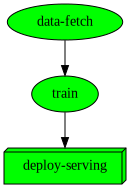

uid,start,state,name,parameters,results
...01bfc437,Apr 25 13:22:21,completed,train,,accuracy=0.9f1_score=0.923076923076923precision_score=1.0recall_score=0.8571428571428571
...4935ccaf,Apr 25 13:21:52,completed,data-fetch,,


cb8eb7b5-b732-4122-b079-762852456f10

In [16]:
# run workflow named main and wait for pipeline completion (watch=True)
project.run('main',watch=True,engine="remote:kfp")

**Run Schedule workflow**

For more inforation about scheduling workflows, please check this [link](https://docs.mlrun.org/en/latest/concepts/scheduled-jobs.html)

In [17]:
project.run('main',watch=True,schedule='0 * * * *')

> 2023-04-25 13:24:23,322 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-04-25 13:24:23,326 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-04-25 13:24:23,332 [info] Storing function: {'name': 'main', 'uid': '6a27afb9ccda40b89d3e38e9053c9fed', 'db': 'http://mlrun-api:8080'}
> 2023-04-25 13:24:23,686 [info] task schedule created: {'schedule': '0 * * * *', 'project': 'my-load-proj-1', 'name': 'main'}
